# This method is pretty cool and looks like it's more precised than the other

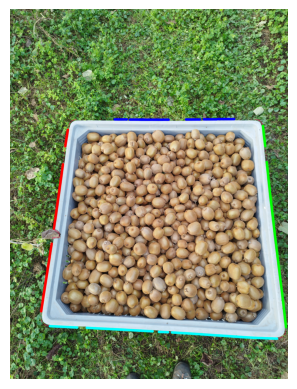

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def draw_lines(image, lines, color=(0, 255, 0), thickness=25):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

def show_image(img, title=""):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

    plt.axis('off')
    if title != "":
        plt.title(title)
    plt.show()

# Read the image
image = cv2.imread("../dataset/IMG_20231028_170944.jpg")
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_color = (79, 0, 179)
upper_color = (128, 255, 255)

# Create a binary mask based on color segmentation
thresh = cv2.inRange(hsv, lower_color, upper_color)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
dilated = cv2.dilate(morph, kernel, iterations=2)

# # Apply GaussianBlur to reduce noise
blurred = cv2.GaussianBlur(dilated, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, 100, 150)

# Combine color and edge masks - looks like it's adding noise
combined_mask = cv2.bitwise_or(dilated, edges)

# # Find contours in the combined mask
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the maximum area (assumed to be the bin)
max_contour = max(contours, key=cv2.contourArea)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=5, minLineLength=100, maxLineGap=50)

# Set your threshold distance
threshold_distance = 10

# Define the center of the image
image_center_x = image.shape[1] // 2
image_center_y = image.shape[0] // 2

# Iterate through the lines and keep only those that are close to the contour
left_lines, right_lines, top_lines, bottom_lines, gen_lines = [], [], [], [], []

for line in lines:
    x1, y1, x2, y2 = line[0]
    line_center = ((x1 + x2) / 2.0, (y1 + y2) / 2.0)  # Use floating-point coordinates

    # Check if the line center is within the contour (use cv2.pointPolygonTest)
    distance = cv2.pointPolygonTest(max_contour, line_center, True)

    # Keep the line if the distance is within the threshold
    if abs(distance) < threshold_distance:
        # Calculate the slope of the line
        slope = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else np.inf
        angle = (np.degrees(np.arctan(slope)))

        # Classify lines into left, right, top, and bottom groups based on angle and position
        if -90< angle < -10 and x1 < image_center_x and x2 < image_center_x:
            left_lines.append(line)
        elif 10 < angle < 90 and x1 > image_center_x and x2 > image_center_x:
            right_lines.append(line)
        elif -10 <= angle <= 10 and y1 < image_center_y and y2 < image_center_y:
            top_lines.append(line)
        elif -10 <= angle <= 10 and y1 > image_center_y and y2 > image_center_y:
            bottom_lines.append(line)
        else:
            gen_lines.append(line)

# SHOWING STUFF

t = image.copy() 
cv2.drawContours(t, max_contour, -1, (100,2,255), 3)

draw_lines(t, left_lines, color=(0, 0, 255))  # Red
draw_lines(t, right_lines, color=(0, 255, 0))  # Green
draw_lines(t, top_lines, color=(255, 0, 0))  # Blue
draw_lines(t, bottom_lines, color=(255, 255, 0))  # Yellow
# draw_lines(t, gen_lines, color=(255, 0, 255))  # Yellow

show_image(t)
# cv2.imwrite("/plot/tmp--1.png", t)



# epsilon = 0.02 * cv2.arcLength(max_contour, True)
# approx_contour = cv2.approxPolyDP(max_contour, epsilon, True)

# # Apply convex hull to get the most convex polygon
# hull = cv2.convexHull(approx_contour)


# # Draw the contour on the original image
# result = image.copy()
# cv2.drawContours(result, [approx_contour], 0, (0, 0, 255), 10)

# show_image(result)
# cv2.imwrite("tmp-copy.png", result)



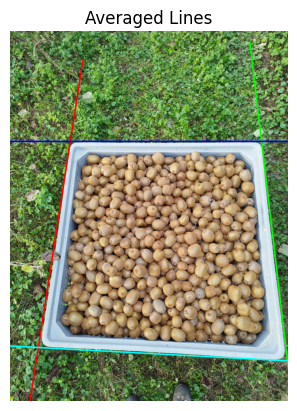

True

In [6]:
def project_avg_line(image, lines, color=(0, 255, 0), thickness=2):
    if len(lines) == 0:
        return

    # Extract angles and positions of all lines
    angles = [np.degrees(np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0])) for line in lines]
    positions = np.array([[(line[0][0] + line[0][2]) / 2, (line[0][1] + line[0][3]) / 2] for line in lines], dtype=np.float32)

    # Calculate the average angle and position
    avg_angle = np.mean(angles)
    avg_position = np.mean(positions, axis=0)

    # Calculate the start and end points of the averaged line
    length = max(image.shape[0], image.shape[1]) // 2
    x1 = int(avg_position[0] - length * np.cos(np.radians(avg_angle)))
    y1 = int(avg_position[1] - length * np.sin(np.radians(avg_angle)))
    x2 = int(avg_position[0] + length * np.cos(np.radians(avg_angle)))
    y2 = int(avg_position[1] + length * np.sin(np.radians(avg_angle)))

    # Draw the averaged line
    cv2.line(image, (x1, y1), (x2, y2), color, thickness)

# Example usage
image_lines = cv2.imread("../dataset/IMG_20231028_170944.jpg")

# Assuming left_lines, right_lines, top_lines, bottom_lines are already obtained
project_avg_line(image_lines, left_lines, color=(0, 0, 255), thickness=15)
project_avg_line(image_lines, right_lines, color=(0, 255, 0), thickness=15)
project_avg_line(image_lines, top_lines, color=(255, 0, 0), thickness=15)
project_avg_line(image_lines, bottom_lines, color=(255, 255, 0), thickness=15)

show_image(image_lines, 'Averaged Lines')
cv2.imwrite("plot/tmp.png", image_lines)